### Workspace

In [74]:
%matplotlib notebook

from modsim import *

In [75]:
altitude = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 
            8000, 9000, 10000, 15000, 20000, 25000, 30000,
           40000, 50000, 60000, 70000, 80000]
density = [1.225, 1.112, 1.007, .9093, .8194, .7364, .6601,
          .5900, .5258, .4671, .4135, .1948, .08891, .04008,
          .01841, .003996, .001027, .0003097, .00008283, .000001846]

dd_da = TimeSeries()
for i in range(20):
    x = altitude[i]
    y = density[i]
    dd_da[x] = y

dd_da = interpolate(dd_da, kind='cubic')

In [76]:
condition = Condition(height=90000,
                      thrust_on=200,
                      f_thrust=20,
                      mass=1,
                      length=.1,
                      width=.1,
                      dd_da=dd_da,
                      C_d=1,
                      g=9.8,
                      dt=1,
                      t_end=500)

In [131]:
def make_system(condition):
    unpack(condition)
    
    init = State(height=height, velocity=0)
    
    drag_coef = -C_d*length*width / 2
    
    steps = (t_end)/dt + 1
    series = linspace(0,t_end, steps)
    
    system = System(init=init,
                    series=series,
                    dt=dt,
                    thrust_on=thrust_on,
                    f_thrust=f_thrust,
                    mass=mass,
                    drag_coef=drag_coef,
                    dd_da=dd_da,
                    t1=-1, t2=-1,
                    t_end=t_end)
    return system

def slope(state, system, dt, count):
    unpack(system)
    height, velocity = state
    
    if (height < thrust_on):
        f_t=f_thrust
    else:
        f_t=0
    
    f_drag = drag_coef * abs(velocity) * velocity * abs(dd_da(height))
    #print(f_drag)
    a_drag = f_drag/mass

    a_thrust = f_t/mass
    a_grav = -g
    a = a_grav + a_thrust + a_drag
    dV = a*dt
    velocity += dV
    
    dH = velocity*dt
    height += dH
    
    if(system.t1==-1 and a_thrust > 0 and a > 0):
        system.t1=dt*count
        #print(system.t1)
    elif(velocity < 0 and system.t1 != -1 and system.t2 == -1):
        system.t2 = dt*count
        #print(system.t2)
        
    return State(height=height, velocity=velocity)

def run_ode_better(system, slope_func):
    count = 0
    unpack(system)
    frame = TimeFrame(columns=init.index)
    
    frame.loc[0] = init
    for i in series:
        if(i < t_end):
            frame.loc[i+dt] = slope_func(frame.loc[i], system, dt, count)
        else:
            system.results = frame
        count += 1
    system.count = count
    
def plot_height(results):
    newfig()
    unpack(results)
    
    plot(height, label='y')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

    
def plot_velocity(results):
    newfig()
    unpack(results)
    
    plot(velocity, label='v')
    
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m)')
    
def height_at_zero(system):
    unpack(system)
    if(t1 < 0):
        return print("error, t1 is less than 0. William done messed up")
    velocity = system.results.velocity[t1:t2]
    t = interp_inverse(velocity)
    
    time = t(0)
    y = interpolate(system.results.height)
    height = y(time)
    return height

def run_simulation():
    system = make_system(condition)
    run_ode_better(system, slope)
    
    system.final_height = height_at_zero(system)
    
    return system

In [132]:
condition.set(dt=.25)
condition.set(t_end = 20)
condition.set(height = 100)
condition.set(thrust_on = 5)

#run2 = make_system(condition)
#run_ode_better(run2, slope)
run1 = run_simulation()
#print(run2)

In [133]:
condition.set(thrust_on = 44)
run2=run_simulation()
run2.final_height

array(101.32682134847984)

In [134]:
run2.results

,height,velocity
0.00,100.000000,0.000000
0.25,99.387500,-2.450000
0.50,98.164776,-4.890896
0.75,96.338623,-7.304610
1.00,93.920209,-9.673658
1.25,90.924797,-11.981649
1.50,87.371364,-14.213732
1.75,83.282125,-16.356954
2.00,78.681993,-18.400527
2.25,73.598000,-20.335974


<IPython.core.display.Javascript object>


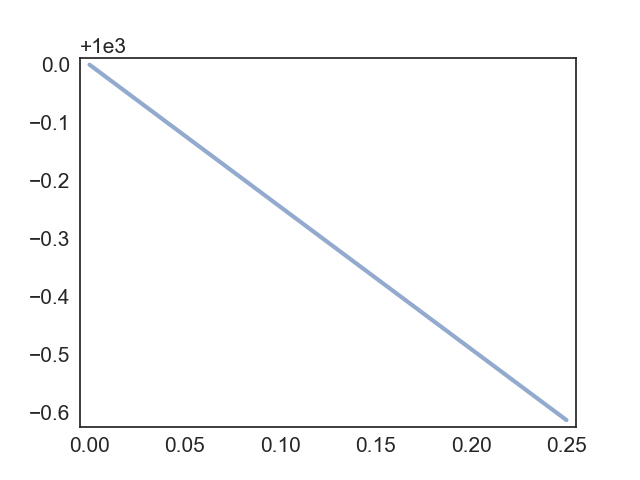

In [118]:
test=run2.results.height[run2.t1:run2.t2]
newfig()
plot(test)

<IPython.core.display.Javascript object>


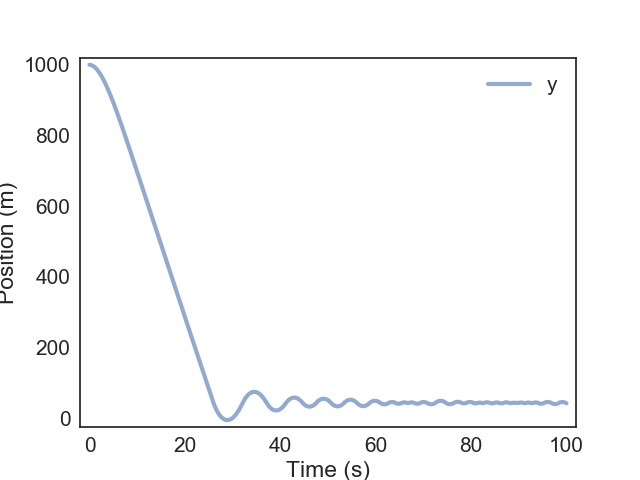

In [112]:
plot_height(run2.results)

<IPython.core.display.Javascript object>


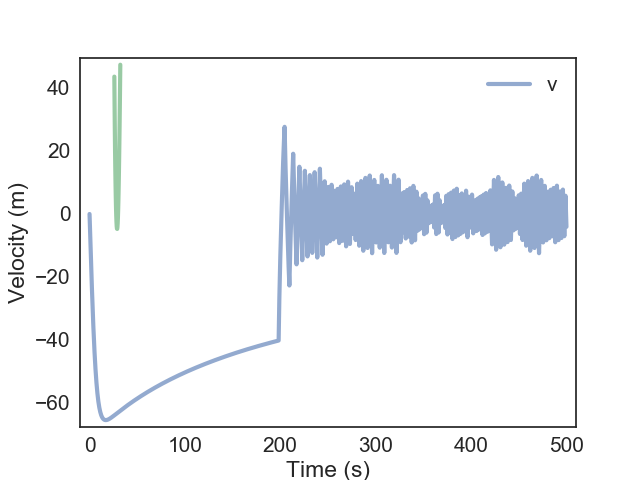

In [81]:
plot_velocity(run1.results)

In [85]:
sweep = SweepSeries()
condition.set(dt=.25)
condition.set(t_end=100)
condition.set(height=1000)
for i in linrange(1, 10, 1):
    condition.set(thrust_on=i)
    system = make_system(condition)
    run_ode_better(system, slope)
    sweep[i] = height_at_zero(system)
    print(i)
sweep

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


,value
1,-54.66653781960351
2,-54.66653781960351
3,-54.66653781960351
4,-44.67845787470205
5,-44.67845787470205
6,-44.67845787470205
7,-44.67845787470205
8,-44.67845787470205
9,-44.67845787470205
10,-44.67845787470205
